In [1]:
import gymnasium as gym
import gymnasium_2048 
import numpy as np
import matplotlib.pyplot as plt
import sys
import torch
from tqdm import tqdm
import pathlib
import os
import time
from itertools import product
import pandas as pd
sys.path.append("..")

from simulations.base_agents import RandomAgent, MonteCarloAgent, ExpectimaxAgent, NNAgent
from simulations.features import MetricsRecorder, feature_names
from simulations.run import run_episode, EpisodeRunner   

%load_ext autoreload
%autoreload 2

In [2]:
ENV_ID = "gymnasium_2048/TwentyFortyEight-v0"

## Random Agent (simulation example)

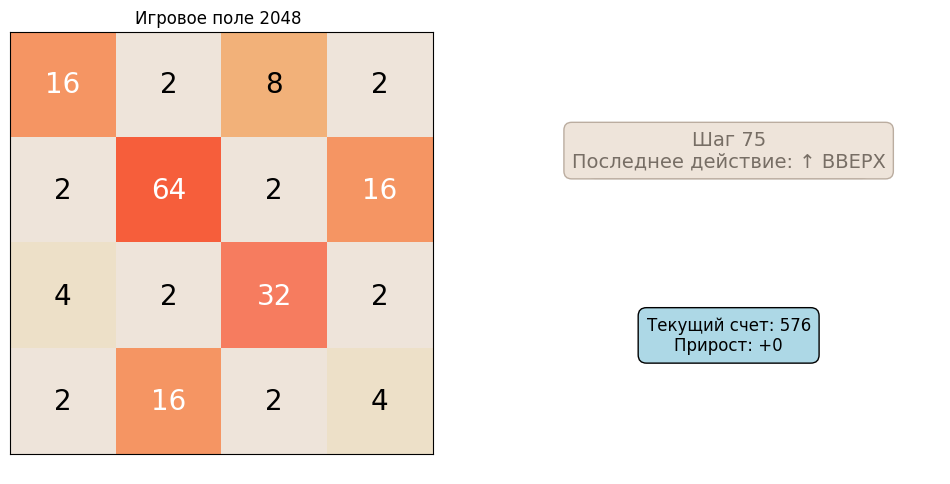


===== Финал =====
Игра завершена (ходов сыграно: 76)
Итоговый счёт: 576


576

In [5]:
env = gym.make(ENV_ID)
agent = RandomAgent(env) 
run_episode(env, agent, on_illegal="ask")

In [3]:
env = gym.make(ENV_ID)
scores = []
for _ in tqdm(range(100)):
    agent = RandomAgent(env) 
    score = run_episode(env, agent, visualize=False, on_illegal="ask")
    scores.append(score)
    
print(np.mean(scores))

100%|██████████| 100/100 [00:01<00:00, 61.78it/s]

1154.04


## MCTS

In [3]:
grid = {
    'rollouts': [10, 30, 50], 
    'rollout_depth': [1, 3, 5, 8, 12]
}

In [4]:
combinations = list(product(*grid.values()))
grid_eval_dict = {
    'rollouts': [], 
    'rollout_depth': [], 
    'avg_score30': []
}
scores_dict = {}
len(combinations)

15

In [15]:
grid_eval_dict = {
    'rollouts': [10, 10, 10, 10, 10, 30, 30, 30, 30, 30, 50, 50, 50, 50, 50], 
    'rollout_depth': [1, 3, 5, 8, 12, 1, 3, 5, 8, 12, 1, 3, 5, 8, 12], 
    'avg_score30': [5286.666666666667, 4210.0, 4701.333333333333, 3315.3333333333335, 3251.866666666667, 5429.6, 4094.6666666666665, 4510.266666666666, 3760.5333333333333, 4258.4, 4580.0, 4672.4, 4137.6, 3767.866666666667, 3672.8]
}
scores_dict = {
    '(10, 1)': [3200, 3044, 8752, 5768, 2780, 15784, 2784, 3784, 6052, 7008, 3840, 2672, 5276, 3368, 6812, 5768, 6720, 6528, 6860, 3152, 3888, 4980, 5460, 3452, 6296, 7060, 5132, 4164, 5376, 2840], 
    '(10, 3)': [5404, 5404, 2932, 3136, 3108, 3060, 2324, 6752, 3236, 3420, 2748, 3168, 3240, 5584, 3132, 6772, 5152, 5160, 1464, 7048, 2800, 3308, 7188, 3040, 6084, 7708, 4660, 3164, 3252, 2852], 
    '(10, 5)': [3288, 2260, 5748, 6456, 612, 3060, 3344, 5440, 6436, 6864, 5268, 5564, 2840, 6156, 5000, 5316, 3260, 12236, 7064, 2904, 2712, 5336, 3028, 1336, 6340, 5376, 5368, 3912, 2128, 6388], 
    '(10, 8)': [5420, 2780, 2996, 4676, 1232, 7024, 1452, 1628, 2428, 4920, 1312, 1296, 3416, 2876, 3096, 5100, 3112, 6928, 3440, 3140, 2316, 1272, 2308, 1404, 6324, 2336, 2760, 3068, 6480, 2920], 
    '(10, 12)': [4172, 3168, 5056, 5296, 3168, 1400, 5392, 2976, 3172, 3112, 1336, 2440, 3000, 5256, 3044, 6308, 3172, 3232, 1344, 2788, 2320, 2996, 2384, 3048, 5424, 3016, 3032, 2312, 2820, 1372], 
    '(30, 1)': [3228, 8200, 4100, 8556, 3120, 8304, 8184, 5704, 5748, 6880, 6736, 6536, 3456, 4760, 3524, 2488, 4808, 5624, 3236, 6612, 7176, 1636, 6332, 5544, 6076, 716, 7152, 10540, 4432, 3480], 
    '(30, 3)': [5476, 3004, 5364, 1256, 6300, 7060, 6380, 2944, 6712, 2864, 3168, 1516, 4576, 2356, 5340, 5524, 3156, 3108, 3084, 3008, 6300, 1860, 5536, 3116, 3188, 6988, 3168, 2920, 6244, 1324], 
    '(30, 5)': [5384, 2480, 6488, 3544, 6176, 5512, 5380, 5368, 5384, 6728, 6928, 3136, 3036, 3644, 3064, 6888, 2296, 3432, 2976, 5400, 3232, 3080, 6168, 3560, 2860, 2408, 2764, 5324, 6480, 6188], 
    '(30, 8)': [3176, 2992, 2664, 5300, 5476, 5420, 3048, 3108, 2400, 2808, 3112, 4948, 2360, 1208, 3664, 5344, 6400, 5588, 5400, 4860, 6292, 2488, 3132, 2400, 3256, 2500, 5376, 2672, 3112, 2312], 
    '(30, 12)': [3004, 1292, 2828, 4968, 3084, 5464, 6728, 4576, 1736, 7044, 3168, 1276, 6320, 5264, 2404, 6300, 3132, 1288, 4484, 6356, 2968, 5684, 6328, 5436, 3056, 6316, 1344, 6848, 3008, 6048], 
    '(50, 1)': [5828, 3380, 3140, 5316, 1684, 2484, 3472, 12116, 3228, 3120, 7452, 5236, 4644, 4816, 2664, 3360, 4912, 3288, 6908, 5840, 1564, 3796, 3104, 3972, 5548, 3140, 5896, 7332, 3060, 7100], 
    '(50, 3)': [4688, 10460, 5408, 3496, 1120, 5488, 5300, 3260, 3012, 5332, 3356, 5972, 3260, 1508, 5172, 6936, 1584, 4516, 6340, 6984, 6440, 5820, 4660, 7008, 2980, 3148, 7340, 3100, 3080, 3404], 
    '(50, 5)': [5164, 5072, 3040, 2864, 2752, 2876, 6320, 4672, 3332, 7016, 2796, 6028, 5292, 6672, 2844, 3064, 3048, 3112, 3072, 3124, 3108, 3156, 1324, 3424, 6980, 2300, 6548, 5048, 7000, 3080], 
    '(50, 8)': [4584, 1332, 568, 4512, 3064, 3176, 5472, 2348, 7056, 3084, 3004, 1444, 3040, 5524, 5080, 3372, 3296, 2320, 5040, 7100, 3016, 3052, 7140, 5392, 2988, 2992, 2348, 5408, 3040, 3244], 
    '(50, 12)': [1256, 3368, 3060, 1308, 5324, 7092, 5372, 3268, 2780, 1292, 4924, 4196, 1332, 3208, 4544, 2932, 3164, 5392, 3420, 3108, 5436, 3108, 7104, 2728, 6440, 3116, 2644, 1384, 2456, 5428]
}

In [14]:
df = pd.DataFrame(grid_eval_dict)
df.sort_values(by='avg_score30', ascending=False)

,rollouts,rollout_depth,avg_score30
5,30,1,5429.600000
0,10,1,5286.666667
2,10,5,4701.333333
11,50,3,4672.400000
10,50,1,4580.000000
7,30,5,4510.266667
9,30,12,4258.400000
1,10,3,4210.000000
12,50,5,4137.600000
6,30,3,4094.666667


In [16]:
# grid_eval_dict = {
#     'rollouts': [], 
#     'rollout_depth': [], 
#     'avg_score25': []
# }
# scores_dict = {}

# for comb in list(product(*grid.values())):
#     scores_dict[f'{comb}'] = []
    
#     rollouts = comb[0]
#     rollout_depth = comb[1]
    
#     grid_eval_dict['rollouts'].append(rollouts)
#     grid_eval_dict['rollout_depth'].append(rollout_depth)
#     summ = 0
    
#     for ep in range (1, 26): 
#         env = gym.make(ENV_ID)
#         agent = MonteCarloAgent(rollouts=rollouts, rollout_depth=rollout_depth)
#         score = run_episode(env, agent, **{'add_to_title': f'episode {ep}: {rollouts} rollouts, {rollout_depth} rollout_depth'}) 
#         scores_dict[f'{comb}'].append(score)
#         summ += score 
        
#         if ep == 25:
#             avg = summ / ep
#             grid_eval_dict[f'avg_score{ep}'].append(avg)

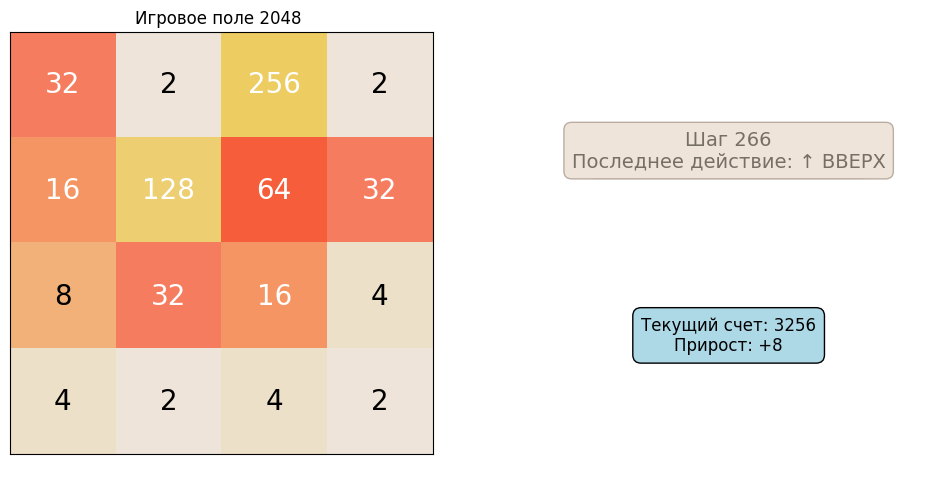


===== Финал =====
Игра завершена (ходов сыграно: 267)
Итоговый счёт: 3256


In [6]:
env = gym.make(ENV_ID)
agent = MonteCarloAgent(rollouts=30, rollout_depth=1)
score = run_episode(env, agent) 

## NN  agent

In [20]:
env = gym.make(ENV_ID)
agent = NNAgent(env)
agent.load_weights('weights_ep5000.pth')
agent.model.eval()

Net(
  (conv1): Conv2d(16, 128, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(128, 128, kernel_size=(2, 2), stride=(1, 1))
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=4, bias=True)
)

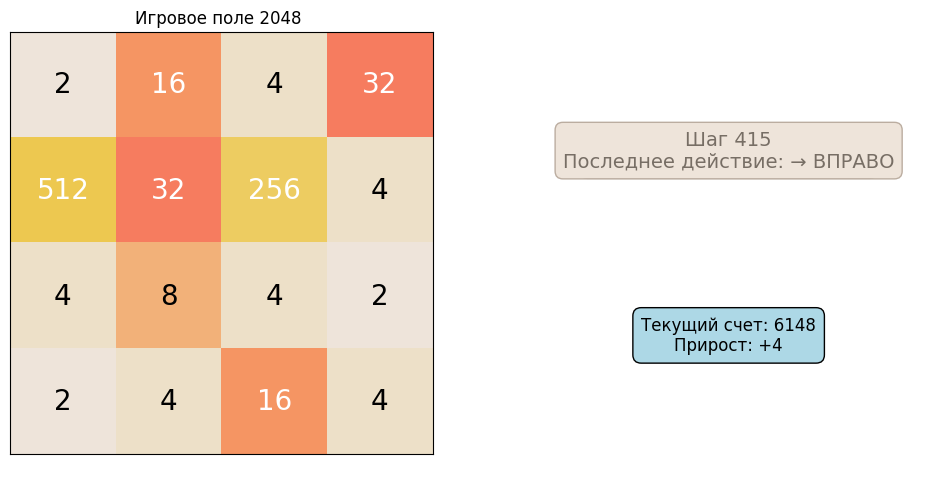


===== Финал =====
Игра завершена (ходов сыграно: 416)
Итоговый счёт: 6148


6148

In [22]:
run_episode(env, agent)

## Expectimax agent

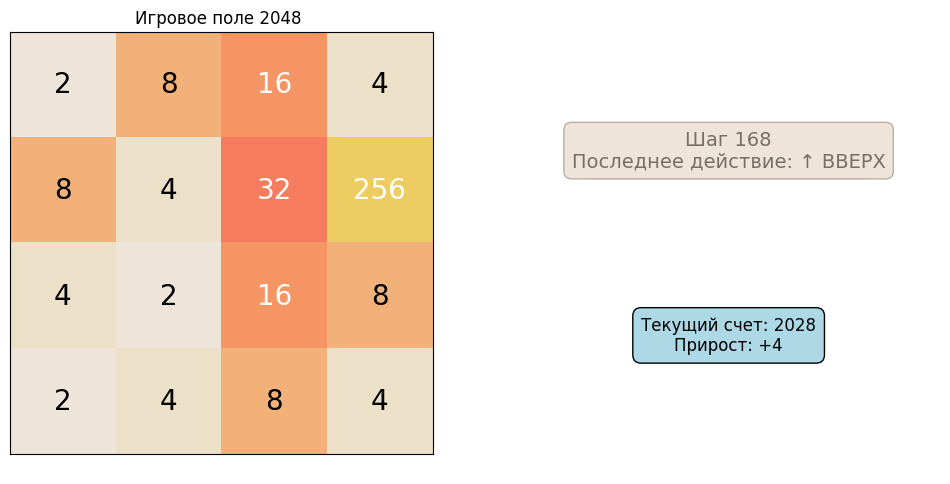


===== Финал =====
Игра завершена (ходов сыграно: 169)
Итоговый счёт: 2028


2028

In [8]:
# Создаём среду
env = gym.make(ENV_ID)
agent = ExpectimaxAgent(depth=3) 
run_episode(env, agent, visualize=True)